<a href="https://colab.research.google.com/github/Nishimura35/weatherwise-marina-nishimura/blob/main/submission/weatherwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **⚙️ Setup and Configuation**
⚠️ Please run this code first

In [ ]:
# =====================================
# 1. Setup and Configuation
# =====================================
!pip install pyinputplus
!pip install fetch-my-weather

import os
import re

import json
from IPython.display import display, HTML
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip

import fetch_my_weather

os.environ['HANDS_ON_AI_SERVER'] = 'https://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'

In [ ]:
# =====================================
# 2. Natural Language Processing
# =====================================
# Parse question
def parse_weather_question_ai(question):
    prompt = f"""
    Extract location, number of forecast days (1-5), and attribute (temperature, rain, outfit advice, general)
    from this question. Respond ONLY in JSON format like this:
    {{
      "location": "...",
      "forecast_days": ...,
      "attribute": "..."
    }}

    Question: "{question}"
    """

    response_text = get_ai_advice(prompt)
    try:
        parsed = json.loads(response_text)
        return parsed
    except json.JSONDecodeError:
        return {"location": None, "forecast_days": 1, "attribute": None}
    weather_data = get_weather_data(
      location=location,
      forecast_days=forecast_days,
      units='m'
    )


# Create prompt
def create_clothing_prompt_en(forecast):
    prompt = "Here is the weather forecast. Based on this information, please provide clothing advice in English.\n\n"
    for day in forecast:
        prompt += (f"Day {day['day']}: Weather: {day['condition']}, "
                   f"High: {day['high_temp']}°C, Low: {day['low_temp']}°C, "
                   f"Precipitation: {day['precipitation_mm']}mm\n")
    prompt += "\n👕 Clothing Advice:"
    return prompt


# Get AI advice
def get_ai_advice(prompt):
    try:
        response = requests.post(
            os.environ['HANDS_ON_AI_SERVER'] + "/v1/chat/completions",
            json={
                "model": os.environ['HANDS_ON_AI_MODEL'],
                "messages": [{"role": "user", "content": prompt}]
            },
            timeout=10
        )
        if response.status_code == 200:
            result = response.json()
            return result["choices"][0]["message"]["content"]
        else:
            return "Failed to get a response from the AI."
    except Exception as e:
        return f"Connection error to AI server: {e}"


# =====================================
# 3. Weather Data Functions
# =====================================
# Get weather data
def get_weather_data(location: str, forecast_days: int = 3, units='m') -> dict:
  try:
    if forecast_days < 1 or forecast_days > 5:
      return {"error": "forecast_days must be between 1 and 5"}

    response = fetch_my_weather.get_weather(
      location=location,
      units=units,
      view_options=str(forecast_days)
    )

    forecast = []
    raw_text = str(response)
    condition_pattern = r"weatherDesc=\[WeatherDesc\(value='([^']+)'\)\]"
    conditions = re.findall(condition_pattern, raw_text)

    max_temps = re.findall(r"maxtempC='(\d+)'", raw_text)
    min_temps = re.findall(r"mintempC='(\d+)'", raw_text)
    precips = re.findall(r"precipMM='([\d.]+)'", raw_text)

    for i in range(forecast_days):
      if i < len(max_temps) and i < len(min_temps) and i < len(precips):
        high = int(max_temps[i])
        low = int(min_temps[i])
        rain = float(precips[i])
        condition = conditions[i] if i < len(conditions) else "Unknown"

        forecast.append({
          "day": i + 1,
          "condition": condition,
          "high_temp": high,
          "low_temp": low,
          "precipitation_mm": float(rain)
        })

    return {
      "location": location,
      "forecast_days": len(forecast),
      "forecast": forecast
    }

  # Connection error
  except ConnectionError:
    print("Network error. Please check your connection and try again.")
    return None

  # Value error
  except ValueError as ve:
    print(f"Invalid input value: {ve}")
    return None

  # Unexpected error
  except Exception as e:
    print(f"An unexpected error occurred: {e}")
    return None

# Get day label
def get_day_label(day_number):
    if day_number == 1:
        return "Today"
    elif day_number == 2:
        return "Tomorrow"
    elif day_number == 3:
        return "Day after tomorrow"
    else:
        return f"Day {day_number}"


# =====================================
# 4. Visualisation Functions
# =====================================
# Show the weather forecast
def create_visualisation(forecast, location, output_type='display'):
  days = [entry['day'] for entry in forecast]
  high_temps = [entry['high_temp'] for entry in forecast]
  low_temps = [entry['low_temp'] for entry in forecast]
  precipitation = [entry['precipitation_mm'] for entry in forecast]

  fig, ax1 = plt.subplots(figsize=(10, 6))

  # Plot temperature lines on left y-axis
  ax1.plot(days, high_temps, color='red', marker='o', label='High Temp (°C)')
  ax1.plot(days, low_temps, color='blue', marker='o', label='Low Temp (°C)')
  ax1.set_xlabel('Day')
  ax1.set_ylabel('Temperature (°C)')
  ax1.legend(loc='upper left')
  ax1.set_ylim(0, 40)

  # Create second y-axis for precipitation bars
  ax2 = ax1.twinx()
  ax2.bar(days, precipitation, alpha=0.3, color='blue', label='Precipitation (mm)')
  ax2.set_ylabel('Precipitation (mm)')
  ax2.legend(loc='upper right')
  ax2.set_ylim(0, 10)

  for i, condition in enumerate([entry.get('condition', '') for entry in forecast]):
    ax1.annotate(
      condition,
      (days[i], high_temps[i] + 1),
      textcoords="offset points",
      xytext=(0, 5),
      ha='center',
      fontsize=8,
      color='darkgreen'
    )

  plt.title(f'Weather Forecast for {location}: Temperature and Precipitation')
  plt.tight_layout()
  safe_location = re.sub(r'\W+', '_', location)

  if output_type == 'figure':
    return fig
  elif output_type == 'save':
    plt.savefig(f"{forecast[0]['day']}_{safe_location}_forecast.png")
    print("Graph saved!")
    plt.close(fig)
  else:
    plt.show()
    plt.close(fig)

# Display weather forecast
def display_forecast(weather_data, days):
    print(f"Weather forecast for {weather_data.nearest_area[0].areaName[0].value}:\n")

    for day in weather_data.weather[:days]:
        date = day.date
        desc = day.hourly[4].weatherDesc[0].value.strip()
        max_temps = day.maxtempC
        min_temps = day.mintempC
        print(f"{date}: {desc}, Max: {max_temps}°C, Min: {min_temps}°C")


# =====================================
# 5. Main function
# =====================================
# Style
display(HTML('''
  <style>
  body {
    background-color: #f0f8ff !important;
  }
  </style>
  <div style="background-color: #f0f8ff; padding: 10px; border-radius: 10px;">
      <h2 style="color: #2e8b57;">🌤️ Weatherwise App</h2>
      <p style="font-size: 16px;">Get your outfit advice with style!</p>
  </div>
'''))

# Main
def main():
  print("Hi I'm Weatherwise App!")
  print("I can help you check the weather forecast.\n")

  while True:
    try:
      question = input("Ask me something about the weather:\n")
      parsed = parse_weather_question_ai(question)

      location = parsed.get("location") if parsed else None
      forecast_days = parsed.get("forecast_days", 1) if parsed else None

      while not location:
        location_input = input("Sorry, I didn't catch the location. Could you please tell me the city or place?\n").strip()
        parsed_location = parse_weather_question_ai(location_input)
        location = parsed_location.get("location") if parsed_location else None
        if not location:
          print("Still can't catch the location. Please try again.")

      while not forecast_days or not (1 <= forecast_days <= 3):
        days_input = input("How many days of forecast would you like? (1-3 days)\n").strip()
        try:
          parsed_days = parse_weather_question_ai(days_input)
          forecast_days_candidate = parsed_days.get("forecast_days") if parsed_days else None

          if forecast_days_candidate is None:
              forecast_days_candidate = int(days_input)

          if 1 <= forecast_days_candidate <= 3:
              forecast_days = forecast_days_candidate
          else:
              print("Please enter a number between 1 and 3.")
              forecast_days = None
        except ValueError:
          print("Please enter a valid number.")

      weather_data = get_weather_data(location=location, forecast_days=forecast_days)

      if not weather_data:
        print("Oops! No weather data returned.")
      elif "error" in weather_data:
        print(f"Oops! Something went wrong: {weather_data['error']}")
      elif not weather_data.get("forecast"):
        print("Oops! No forecast data received. Please try a different location or day range.")
      else:
        for day in weather_data["forecast"]:
          day_label = get_day_label(day['day'])
          print(f"- {day_label}: {day['condition']}, High: {day['high_temp']}°C, "
          f"Low: {day['low_temp']}°C, Precipitation: {day['precipitation_mm']} mm\n")

        create_visualisation(weather_data["forecast"], location)
        prompt_en = create_clothing_prompt_en(weather_data["forecast"])
        advice_en = get_ai_advice(prompt_en)
        print("\033[1m\n👕 CLOTHING ADVICE\033[0m")
        prompt = f"""
        Please answer the weather advice using 'Today', 'Tomorrow', and 'Day after tomorrow' instead of 'Day 1', 'Day 2', etc.
        Here is the weather data: {weather_data}
        """
        advice = get_ai_advice(prompt)
        print(advice)


      again = input("\nCheck another city? (y/yes to continue):\n").strip().lower()
      if again not in ['yes', 'y']:
        print("Goodbye! Have a nice day!")
        break

    except ConnectionError:
      print("It looks like there's a problem with your internet connection. Please check and try again.")
    except Exception as e:
      print(f"Oops! Something went wrong: {e}")
      print("Please try again or contact support if the issue persists.")


# =====================================
# 6. Main Script
# =====================================
if __name__ == '__main__':
    main()

## **< > Code**

In [ ]:
# =====================================
# 2. Natural Language Processing
# =====================================
# Parse question
def parse_weather_question_ai(question):
    prompt = f"""
    Extract location, number of forecast days (1-5), and attribute (temperature, rain, outfit advice, general)
    from this question. Respond ONLY in JSON format like this:
    {{
      "location": "...",
      "forecast_days": ...,
      "attribute": "..."
    }}

    Question: "{question}"
    """

    response_text = get_ai_advice(prompt)
    try:
        parsed = json.loads(response_text)
        return parsed
    except json.JSONDecodeError:
        return {"location": None, "forecast_days": 1, "attribute": None}
    weather_data = get_weather_data(
      location=location,
      forecast_days=forecast_days,
      units='m'
    )


# Create prompt
def create_clothing_prompt_en(forecast):
    prompt = "Here is the weather forecast. Based on this information, please provide clothing advice in English.\n\n"
    for day in forecast:
        prompt += (f"Day {day['day']}: Weather: {day['condition']}, "
                   f"High: {day['high_temp']}°C, Low: {day['low_temp']}°C, "
                   f"Precipitation: {day['precipitation_mm']}mm\n")
    prompt += "\n👕 Clothing Advice:"
    return prompt


# Get AI advice
def get_ai_advice(prompt):
    try:
        response = requests.post(
            os.environ['HANDS_ON_AI_SERVER'] + "/v1/chat/completions",
            json={
                "model": os.environ['HANDS_ON_AI_MODEL'],
                "messages": [{"role": "user", "content": prompt}]
            },
            timeout=10
        )
        if response.status_code == 200:
            result = response.json()
            return result["choices"][0]["message"]["content"]
        else:
            return "Failed to get a response from the AI."
    except Exception as e:
        return f"Connection error to AI server: {e}"


# =====================================
# 3. Weather Data Functions
# =====================================
# Get weather data
def get_weather_data(location: str, forecast_days: int = 3, units='m') -> dict:
  try:
    if forecast_days < 1 or forecast_days > 5:
      return {"error": "forecast_days must be between 1 and 5"}

    response = fetch_my_weather.get_weather(
      location=location,
      units=units,
      view_options=str(forecast_days)
    )

    forecast = []
    raw_text = str(response)
    condition_pattern = r"weatherDesc=\[WeatherDesc\(value='([^']+)'\)\]"
    conditions = re.findall(condition_pattern, raw_text)

    max_temps = re.findall(r"maxtempC='(\d+)'", raw_text)
    min_temps = re.findall(r"mintempC='(\d+)'", raw_text)
    precips = re.findall(r"precipMM='([\d.]+)'", raw_text)

    for i in range(forecast_days):
      if i < len(max_temps) and i < len(min_temps) and i < len(precips):
        high = int(max_temps[i])
        low = int(min_temps[i])
        rain = float(precips[i])
        condition = conditions[i] if i < len(conditions) else "Unknown"

        forecast.append({
          "day": i + 1,
          "condition": condition,
          "high_temp": high,
          "low_temp": low,
          "precipitation_mm": float(rain)
        })

    return {
      "location": location,
      "forecast_days": len(forecast),
      "forecast": forecast
    }

  # Connection error
  except ConnectionError:
    print("Network error. Please check your connection and try again.")
    return None

  # Value error
  except ValueError as ve:
    print(f"Invalid input value: {ve}")
    return None

  # Unexpected error
  except Exception as e:
    print(f"An unexpected error occurred: {e}")
    return None

# Get day label
def get_day_label(day_number):
    if day_number == 1:
        return "Today"
    elif day_number == 2:
        return "Tomorrow"
    elif day_number == 3:
        return "Day after tomorrow"
    else:
        return f"Day {day_number}"


# =====================================
# 4. Visualisation Functions
# =====================================
# Show the weather forecast
def create_visualisation(forecast, location, output_type='display'):
  days = [entry['day'] for entry in forecast]
  high_temps = [entry['high_temp'] for entry in forecast]
  low_temps = [entry['low_temp'] for entry in forecast]
  precipitation = [entry['precipitation_mm'] for entry in forecast]

  fig, ax1 = plt.subplots(figsize=(10, 6))

  # Plot temperature lines on left y-axis
  ax1.plot(days, high_temps, color='red', marker='o', label='High Temp (°C)')
  ax1.plot(days, low_temps, color='blue', marker='o', label='Low Temp (°C)')
  ax1.set_xlabel('Day')
  ax1.set_ylabel('Temperature (°C)')
  ax1.legend(loc='upper left')
  ax1.set_ylim(0, 40)

  # Create second y-axis for precipitation bars
  ax2 = ax1.twinx()
  ax2.bar(days, precipitation, alpha=0.3, color='blue', label='Precipitation (mm)')
  ax2.set_ylabel('Precipitation (mm)')
  ax2.legend(loc='upper right')
  ax2.set_ylim(0, 10)

  for i, condition in enumerate([entry.get('condition', '') for entry in forecast]):
    ax1.annotate(
      condition,
      (days[i], high_temps[i] + 1),
      textcoords="offset points",
      xytext=(0, 5),
      ha='center',
      fontsize=8,
      color='darkgreen'
    )

  plt.title(f'Weather Forecast for {location}: Temperature and Precipitation')
  plt.tight_layout()
  safe_location = re.sub(r'\W+', '_', location)

  if output_type == 'figure':
    return fig
  elif output_type == 'save':
    plt.savefig(f"{forecast[0]['day']}_{safe_location}_forecast.png")
    print("Graph saved!")
    plt.close(fig)
  else:
    plt.show()
    plt.close(fig)

# Display weather forecast
def display_forecast(weather_data, days):
    print(f"Weather forecast for {weather_data.nearest_area[0].areaName[0].value}:\n")

    for day in weather_data.weather[:days]:
        date = day.date
        desc = day.hourly[4].weatherDesc[0].value.strip()
        max_temps = day.maxtempC
        min_temps = day.mintempC
        print(f"{date}: {desc}, Max: {max_temps}°C, Min: {min_temps}°C")


# =====================================
# 5. Main function
# =====================================
# Style
display(HTML('''
  <style>
  body {
    background-color: #f0f8ff !important;
  }
  </style>
  <div style="background-color: #f0f8ff; padding: 10px; border-radius: 10px;">
      <h2 style="color: #2e8b57;">🌤️ Weatherwise App</h2>
      <p style="font-size: 16px;">Get your outfit advice with style!</p>
  </div>
'''))

# Main
def main():
  print("Hi I'm Weatherwise App!")
  print("I can help you check the weather forecast.\n")

  while True:
    try:
      question = input("Ask me something about the weather:\n")
      parsed = parse_weather_question_ai(question)

      location = parsed.get("location") if parsed else None
      forecast_days = parsed.get("forecast_days", 1) if parsed else None

      while not location:
        location_input = input("Sorry, I didn't catch the location. Could you please tell me the city or place?\n").strip()
        parsed_location = parse_weather_question_ai(location_input)
        location = parsed_location.get("location") if parsed_location else None
        if not location:
          print("Still can't catch the location. Please try again.")

      while not forecast_days or not (1 <= forecast_days <= 3):
        days_input = input("How many days of forecast would you like? (1-3 days)\n").strip()
        try:
          parsed_days = parse_weather_question_ai(days_input)
          forecast_days_candidate = parsed_days.get("forecast_days") if parsed_days else None

          if forecast_days_candidate is None:
              forecast_days_candidate = int(days_input)

          if 1 <= forecast_days_candidate <= 3:
              forecast_days = forecast_days_candidate
          else:
              print("Please enter a number between 1 and 3.")
              forecast_days = None
        except ValueError:
          print("Please enter a valid number.")

      weather_data = get_weather_data(location=location, forecast_days=forecast_days)

      if not weather_data:
        print("Oops! No weather data returned.")
      elif "error" in weather_data:
        print(f"Oops! Something went wrong: {weather_data['error']}")
      elif not weather_data.get("forecast"):
        print("Oops! No forecast data received. Please try a different location or day range.")
      else:
        for day in weather_data["forecast"]:
          day_label = get_day_label(day['day'])
          print(f"- {day_label}: {day['condition']}, High: {day['high_temp']}°C, "
          f"Low: {day['low_temp']}°C, Precipitation: {day['precipitation_mm']} mm\n")

        create_visualisation(weather_data["forecast"], location)
        prompt_en = create_clothing_prompt_en(weather_data["forecast"])
        advice_en = get_ai_advice(prompt_en)
        print("\033[1m\n👕 CLOTHING ADVICE\033[0m")
        prompt = f"""
        Please answer the weather advice using 'Today', 'Tomorrow', and 'Day after tomorrow' instead of 'Day 1', 'Day 2', etc.
        Here is the weather data: {weather_data}
        """
        advice = get_ai_advice(prompt)
        print(advice)


      again = input("\nCheck another city? (y/yes to continue):\n").strip().lower()
      if again not in ['yes', 'y']:
        print("Goodbye! Have a nice day!")
        break

    except ConnectionError:
      print("It looks like there's a problem with your internet connection. Please check and try again.")
    except Exception as e:
      print(f"Oops! Something went wrong: {e}")
      print("Please try again or contact support if the issue persists.")


# =====================================
# 6. Main Script
# =====================================
if __name__ == '__main__':
    main()


## **🔧 Testing and Examples 1**

Testing understanding a sentence

Hi I'm Weatherwise App!
I can help you check the weather forecast.

Ask me something about the weather:
How is the weather in Perth for 3 days?
- Today: Clear, High: 23°C, Low: 14°C, Precipitation: 0.0 mm

- Tomorrow: Clear , High: 21°C, Low: 17°C, Precipitation: 0.0 mm

- Day after tomorrow: Cloudy , High: 22°C, Low: 18°C, Precipitation: 0.0 mm



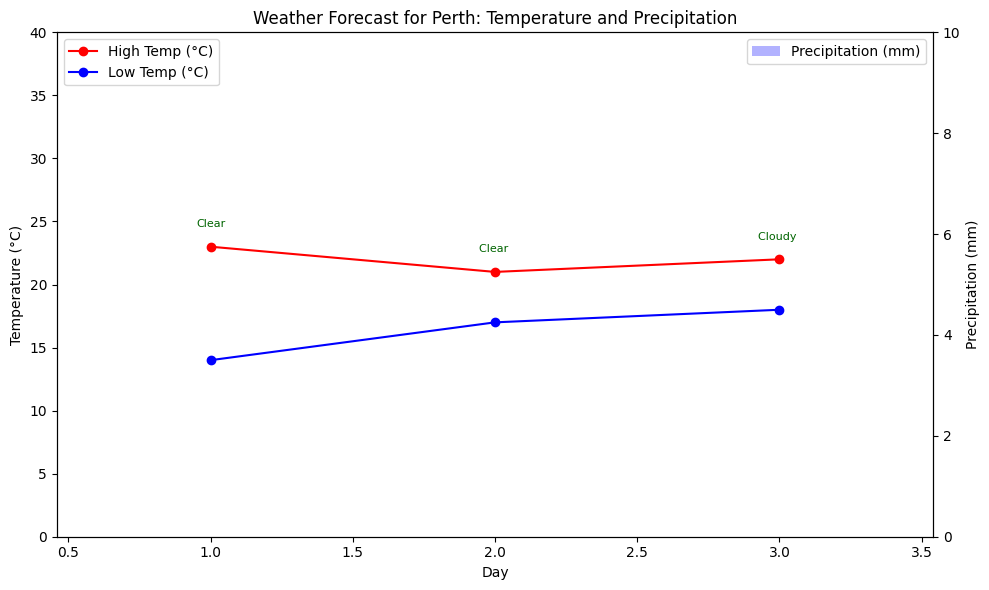


👕 CLOTHING ADVICE
**Weather Advice for Perth:**

**Today (Day 1):** Expect a clear sky with temperatures ranging from a high of 23 degrees to a low of 14 degrees Celsius. There will be no precipitation.

**Tomorrow (Day 2):** Again, it's expected to remain mostly clear with a slight drop in temperature, reaching highs of 21 degrees and lows around 17 degrees Celsius. No rain is predicted.

**Day after Tomorrow (Day 3):** The forecast suggests cloudy skies. Temperatures will be mild, with afternoon highs up to 22 degrees Celsius and a drop to lows of about 18 degrees Celsius. Once more, no rain is expected.

Enjoy your time in Perth - it seems like a pleasant few days ahead weather-wise!

Check another city? (y/yes to continue):
no
Goodbye! Have a nice day!


In [ ]:
# =====================================
# 2. Natural Language Processing
# =====================================
# Parse question
def parse_weather_question_ai(question):
    prompt = f"""
    Extract location, number of forecast days (1-5), and attribute (temperature, rain, outfit advice, general)
    from this question. Respond ONLY in JSON format like this:
    {{
      "location": "...",
      "forecast_days": ...,
      "attribute": "..."
    }}

    Question: "{question}"
    """

    response_text = get_ai_advice(prompt)
    try:
        parsed = json.loads(response_text)
        return parsed
    except json.JSONDecodeError:
        return {"location": None, "forecast_days": 1, "attribute": None}
    weather_data = get_weather_data(
      location=location,
      forecast_days=forecast_days,
      units='m'
    )


# Create prompt
def create_clothing_prompt_en(forecast):
    prompt = "Here is the weather forecast. Based on this information, please provide clothing advice in English.\n\n"
    for day in forecast:
        prompt += (f"Day {day['day']}: Weather: {day['condition']}, "
                   f"High: {day['high_temp']}°C, Low: {day['low_temp']}°C, "
                   f"Precipitation: {day['precipitation_mm']}mm\n")
    prompt += "\n👕 Clothing Advice:"
    return prompt


# Get AI advice
def get_ai_advice(prompt):
    try:
        response = requests.post(
            os.environ['HANDS_ON_AI_SERVER'] + "/v1/chat/completions",
            json={
                "model": os.environ['HANDS_ON_AI_MODEL'],
                "messages": [{"role": "user", "content": prompt}]
            },
            timeout=10
        )
        if response.status_code == 200:
            result = response.json()
            return result["choices"][0]["message"]["content"]
        else:
            return "Failed to get a response from the AI."
    except Exception as e:
        return f"Connection error to AI server: {e}"


# =====================================
# 3. Weather Data Functions
# =====================================
# Get weather data
def get_weather_data(location: str, forecast_days: int = 3, units='m') -> dict:
  try:
    if forecast_days < 1 or forecast_days > 5:
      return {"error": "forecast_days must be between 1 and 5"}

    response = fetch_my_weather.get_weather(
      location=location,
      units=units,
      view_options=str(forecast_days)
    )

    forecast = []
    raw_text = str(response)
    condition_pattern = r"weatherDesc=\[WeatherDesc\(value='([^']+)'\)\]"
    conditions = re.findall(condition_pattern, raw_text)

    max_temps = re.findall(r"maxtempC='(\d+)'", raw_text)
    min_temps = re.findall(r"mintempC='(\d+)'", raw_text)
    precips = re.findall(r"precipMM='([\d.]+)'", raw_text)

    for i in range(forecast_days):
      if i < len(max_temps) and i < len(min_temps) and i < len(precips):
        high = int(max_temps[i])
        low = int(min_temps[i])
        rain = float(precips[i])
        condition = conditions[i] if i < len(conditions) else "Unknown"

        forecast.append({
          "day": i + 1,
          "condition": condition,
          "high_temp": high,
          "low_temp": low,
          "precipitation_mm": float(rain)
        })

    return {
      "location": location,
      "forecast_days": len(forecast),
      "forecast": forecast
    }

  # Connection error
  except ConnectionError:
    print("Network error. Please check your connection and try again.")
    return None

  # Value error
  except ValueError as ve:
    print(f"Invalid input value: {ve}")
    return None

  # Unexpected error
  except Exception as e:
    print(f"An unexpected error occurred: {e}")
    return None

# Get day label
def get_day_label(day_number):
    if day_number == 1:
        return "Today"
    elif day_number == 2:
        return "Tomorrow"
    elif day_number == 3:
        return "Day after tomorrow"
    else:
        return f"Day {day_number}"


# =====================================
# 4. Visualisation Functions
# =====================================
# Show the weather forecast
def create_visualisation(forecast, location, output_type='display'):
  days = [entry['day'] for entry in forecast]
  high_temps = [entry['high_temp'] for entry in forecast]
  low_temps = [entry['low_temp'] for entry in forecast]
  precipitation = [entry['precipitation_mm'] for entry in forecast]

  fig, ax1 = plt.subplots(figsize=(10, 6))

  # Plot temperature lines on left y-axis
  ax1.plot(days, high_temps, color='red', marker='o', label='High Temp (°C)')
  ax1.plot(days, low_temps, color='blue', marker='o', label='Low Temp (°C)')
  ax1.set_xlabel('Day')
  ax1.set_ylabel('Temperature (°C)')
  ax1.legend(loc='upper left')
  ax1.set_ylim(0, 40)

  # Create second y-axis for precipitation bars
  ax2 = ax1.twinx()
  ax2.bar(days, precipitation, alpha=0.3, color='blue', label='Precipitation (mm)')
  ax2.set_ylabel('Precipitation (mm)')
  ax2.legend(loc='upper right')
  ax2.set_ylim(0, 10)

  for i, condition in enumerate([entry.get('condition', '') for entry in forecast]):
    ax1.annotate(
      condition,
      (days[i], high_temps[i] + 1),
      textcoords="offset points",
      xytext=(0, 5),
      ha='center',
      fontsize=8,
      color='darkgreen'
    )

  plt.title(f'Weather Forecast for {location}: Temperature and Precipitation')
  plt.tight_layout()
  safe_location = re.sub(r'\W+', '_', location)

  if output_type == 'figure':
    return fig
  elif output_type == 'save':
    plt.savefig(f"{forecast[0]['day']}_{safe_location}_forecast.png")
    print("Graph saved!")
    plt.close(fig)
  else:
    plt.show()
    plt.close(fig)

# Display weather forecast
def display_forecast(weather_data, days):
    print(f"Weather forecast for {weather_data.nearest_area[0].areaName[0].value}:\n")

    for day in weather_data.weather[:days]:
        date = day.date
        desc = day.hourly[4].weatherDesc[0].value.strip()
        max_temps = day.maxtempC
        min_temps = day.mintempC
        print(f"{date}: {desc}, Max: {max_temps}°C, Min: {min_temps}°C")


# =====================================
# 5. Main function
# =====================================
# Style
display(HTML('''
  <style>
  body {
    background-color: #f0f8ff !important;
  }
  </style>
  <div style="background-color: #f0f8ff; padding: 10px; border-radius: 10px;">
      <h2 style="color: #2e8b57;">🌤️ Weatherwise App</h2>
      <p style="font-size: 16px;">Get your outfit advice with style!</p>
  </div>
'''))

# Main
def main():
  print("Hi I'm Weatherwise App!")
  print("I can help you check the weather forecast.\n")

  while True:
    try:
      question = input("Ask me something about the weather:\n")
      parsed = parse_weather_question_ai(question)

      location = parsed.get("location") if parsed else None
      forecast_days = parsed.get("forecast_days", 1) if parsed else None

      while not location:
        location_input = input("Sorry, I didn't catch the location. Could you please tell me the city or place?\n").strip()
        parsed_location = parse_weather_question_ai(location_input)
        location = parsed_location.get("location") if parsed_location else None
        if not location:
          print("Still can't catch the location. Please try again.")

      while not forecast_days or not (1 <= forecast_days <= 3):
        days_input = input("How many days of forecast would you like? (1-3 days)\n").strip()
        try:
          parsed_days = parse_weather_question_ai(days_input)
          forecast_days_candidate = parsed_days.get("forecast_days") if parsed_days else None

          if forecast_days_candidate is None:
              forecast_days_candidate = int(days_input)

          if 1 <= forecast_days_candidate <= 3:
              forecast_days = forecast_days_candidate
          else:
              print("Please enter a number between 1 and 3.")
              forecast_days = None
        except ValueError:
          print("Please enter a valid number.")

      weather_data = get_weather_data(location=location, forecast_days=forecast_days)

      if not weather_data:
        print("Oops! No weather data returned.")
      elif "error" in weather_data:
        print(f"Oops! Something went wrong: {weather_data['error']}")
      elif not weather_data.get("forecast"):
        print("Oops! No forecast data received. Please try a different location or day range.")
      else:
        for day in weather_data["forecast"]:
          day_label = get_day_label(day['day'])
          print(f"- {day_label}: {day['condition']}, High: {day['high_temp']}°C, "
          f"Low: {day['low_temp']}°C, Precipitation: {day['precipitation_mm']} mm\n")

        create_visualisation(weather_data["forecast"], location)
        prompt_en = create_clothing_prompt_en(weather_data["forecast"])
        advice_en = get_ai_advice(prompt_en)
        print("\033[1m\n👕 CLOTHING ADVICE\033[0m")
        prompt = f"""
        Please answer the weather advice using 'Today', 'Tomorrow', and 'Day after tomorrow' instead of 'Day 1', 'Day 2', etc.
        Here is the weather data: {weather_data}
        """
        advice = get_ai_advice(prompt)
        print(advice)


      again = input("\nCheck another city? (y/yes to continue):\n").strip().lower()
      if again not in ['yes', 'y']:
        print("Goodbye! Have a nice day!")
        break

    except ConnectionError:
      print("It looks like there's a problem with your internet connection. Please check and try again.")
    except Exception as e:
      print(f"Oops! Something went wrong: {e}")
      print("Please try again or contact support if the issue persists.")


# =====================================
# 6. Main Script
# =====================================
if __name__ == '__main__':
    main()


## **🔧 Testing and Examples 2**

Testing simple words.
Testing location that does not exist.

Hi I'm Weatherwise App!
I can help you check the weather forecast.

Ask me something about the weather:
Tokyo 3 days
- Today: Partly cloudy, High: 20°C, Low: 19°C, Precipitation: 0.0 mm

- Tomorrow: Light rain shower, High: 20°C, Low: 17°C, Precipitation: 1.1 mm

- Day after tomorrow: Light rain shower, High: 17°C, Low: 16°C, Precipitation: 0.3 mm



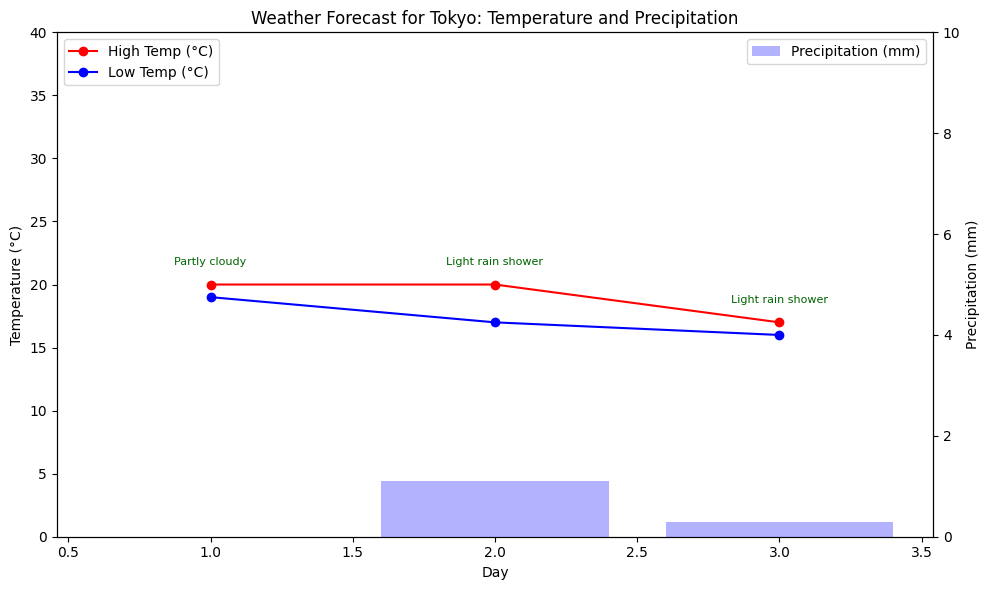


👕 CLOTHING ADVICE
Today in Tokyo, expect partly cloudy skies with a high of 20°C and a low of 19°C. There's no precipitation expected.

Tomorrow will see light rain showers, with high temperature dropping slightly to 20°C but the low dipping to 17°C. Anticipate about 1.1mm of rainfall.

On the day after tomorrow, it's another forecast for light rain showers. The high temperature will fall to 17°C and the low to 16°C. Expect roughly 0.3mm of precipitation this day. 

Please remember to carry an umbrella if you're stepping out during these rainy periods. Stay updated with local forecasts for any changes and stay safe!

Check another city? (y/yes to continue):
y
Ask me something about the weather:
jdiejibvugu
How many days of forecast would you like? (1-3 days)
3
Oops! No forecast data received. Please try a different location or day range.

Check another city? (y/yes to continue):
n
Goodbye! Have a nice day!


In [ ]:
# =====================================
# 2. Natural Language Processing
# =====================================
# Parse question
def parse_weather_question_ai(question):
    prompt = f"""
    Extract location, number of forecast days (1-5), and attribute (temperature, rain, outfit advice, general)
    from this question. Respond ONLY in JSON format like this:
    {{
      "location": "...",
      "forecast_days": ...,
      "attribute": "..."
    }}

    Question: "{question}"
    """

    response_text = get_ai_advice(prompt)
    try:
        parsed = json.loads(response_text)
        return parsed
    except json.JSONDecodeError:
        return {"location": None, "forecast_days": 1, "attribute": None}
    weather_data = get_weather_data(
      location=location,
      forecast_days=forecast_days,
      units='m'
    )


# Create prompt
def create_clothing_prompt_en(forecast):
    prompt = "Here is the weather forecast. Based on this information, please provide clothing advice in English.\n\n"
    for day in forecast:
        prompt += (f"Day {day['day']}: Weather: {day['condition']}, "
                   f"High: {day['high_temp']}°C, Low: {day['low_temp']}°C, "
                   f"Precipitation: {day['precipitation_mm']}mm\n")
    prompt += "\n👕 Clothing Advice:"
    return prompt


# Get AI advice
def get_ai_advice(prompt):
    try:
        response = requests.post(
            os.environ['HANDS_ON_AI_SERVER'] + "/v1/chat/completions",
            json={
                "model": os.environ['HANDS_ON_AI_MODEL'],
                "messages": [{"role": "user", "content": prompt}]
            },
            timeout=10
        )
        if response.status_code == 200:
            result = response.json()
            return result["choices"][0]["message"]["content"]
        else:
            return "Failed to get a response from the AI."
    except Exception as e:
        return f"Connection error to AI server: {e}"


# =====================================
# 3. Weather Data Functions
# =====================================
# Get weather data
def get_weather_data(location: str, forecast_days: int = 3, units='m') -> dict:
  try:
    if forecast_days < 1 or forecast_days > 5:
      return {"error": "forecast_days must be between 1 and 5"}

    response = fetch_my_weather.get_weather(
      location=location,
      units=units,
      view_options=str(forecast_days)
    )

    forecast = []
    raw_text = str(response)
    condition_pattern = r"weatherDesc=\[WeatherDesc\(value='([^']+)'\)\]"
    conditions = re.findall(condition_pattern, raw_text)

    max_temps = re.findall(r"maxtempC='(\d+)'", raw_text)
    min_temps = re.findall(r"mintempC='(\d+)'", raw_text)
    precips = re.findall(r"precipMM='([\d.]+)'", raw_text)

    for i in range(forecast_days):
      if i < len(max_temps) and i < len(min_temps) and i < len(precips):
        high = int(max_temps[i])
        low = int(min_temps[i])
        rain = float(precips[i])
        condition = conditions[i] if i < len(conditions) else "Unknown"

        forecast.append({
          "day": i + 1,
          "condition": condition,
          "high_temp": high,
          "low_temp": low,
          "precipitation_mm": float(rain)
        })

    return {
      "location": location,
      "forecast_days": len(forecast),
      "forecast": forecast
    }

  # Connection error
  except ConnectionError:
    print("Network error. Please check your connection and try again.")
    return None

  # Value error
  except ValueError as ve:
    print(f"Invalid input value: {ve}")
    return None

  # Unexpected error
  except Exception as e:
    print(f"An unexpected error occurred: {e}")
    return None

# Get day label
def get_day_label(day_number):
    if day_number == 1:
        return "Today"
    elif day_number == 2:
        return "Tomorrow"
    elif day_number == 3:
        return "Day after tomorrow"
    else:
        return f"Day {day_number}"


# =====================================
# 4. Visualisation Functions
# =====================================
# Show the weather forecast
def create_visualisation(forecast, location, output_type='display'):
  days = [entry['day'] for entry in forecast]
  high_temps = [entry['high_temp'] for entry in forecast]
  low_temps = [entry['low_temp'] for entry in forecast]
  precipitation = [entry['precipitation_mm'] for entry in forecast]

  fig, ax1 = plt.subplots(figsize=(10, 6))

  # Plot temperature lines on left y-axis
  ax1.plot(days, high_temps, color='red', marker='o', label='High Temp (°C)')
  ax1.plot(days, low_temps, color='blue', marker='o', label='Low Temp (°C)')
  ax1.set_xlabel('Day')
  ax1.set_ylabel('Temperature (°C)')
  ax1.legend(loc='upper left')
  ax1.set_ylim(0, 40)

  # Create second y-axis for precipitation bars
  ax2 = ax1.twinx()
  ax2.bar(days, precipitation, alpha=0.3, color='blue', label='Precipitation (mm)')
  ax2.set_ylabel('Precipitation (mm)')
  ax2.legend(loc='upper right')
  ax2.set_ylim(0, 10)

  for i, condition in enumerate([entry.get('condition', '') for entry in forecast]):
    ax1.annotate(
      condition,
      (days[i], high_temps[i] + 1),
      textcoords="offset points",
      xytext=(0, 5),
      ha='center',
      fontsize=8,
      color='darkgreen'
    )

  plt.title(f'Weather Forecast for {location}: Temperature and Precipitation')
  plt.tight_layout()
  safe_location = re.sub(r'\W+', '_', location)

  if output_type == 'figure':
    return fig
  elif output_type == 'save':
    plt.savefig(f"{forecast[0]['day']}_{safe_location}_forecast.png")
    print("Graph saved!")
    plt.close(fig)
  else:
    plt.show()
    plt.close(fig)

# Display weather forecast
def display_forecast(weather_data, days):
    print(f"Weather forecast for {weather_data.nearest_area[0].areaName[0].value}:\n")

    for day in weather_data.weather[:days]:
        date = day.date
        desc = day.hourly[4].weatherDesc[0].value.strip()
        max_temps = day.maxtempC
        min_temps = day.mintempC
        print(f"{date}: {desc}, Max: {max_temps}°C, Min: {min_temps}°C")


# =====================================
# 5. Main function
# =====================================
# Style
display(HTML('''
  <style>
  body {
    background-color: #f0f8ff !important;
  }
  </style>
  <div style="background-color: #f0f8ff; padding: 10px; border-radius: 10px;">
      <h2 style="color: #2e8b57;">🌤️ Weatherwise App</h2>
      <p style="font-size: 16px;">Get your outfit advice with style!</p>
  </div>
'''))

# Main
def main():
  print("Hi I'm Weatherwise App!")
  print("I can help you check the weather forecast.\n")

  while True:
    try:
      question = input("Ask me something about the weather:\n")
      parsed = parse_weather_question_ai(question)

      location = parsed.get("location") if parsed else None
      forecast_days = parsed.get("forecast_days", 1) if parsed else None

      while not location:
        location_input = input("Sorry, I didn't catch the location. Could you please tell me the city or place?\n").strip()
        parsed_location = parse_weather_question_ai(location_input)
        location = parsed_location.get("location") if parsed_location else None
        if not location:
          print("Still can't catch the location. Please try again.")

      while not forecast_days or not (1 <= forecast_days <= 3):
        days_input = input("How many days of forecast would you like? (1-3 days)\n").strip()
        try:
          parsed_days = parse_weather_question_ai(days_input)
          forecast_days_candidate = parsed_days.get("forecast_days") if parsed_days else None

          if forecast_days_candidate is None:
              forecast_days_candidate = int(days_input)

          if 1 <= forecast_days_candidate <= 3:
              forecast_days = forecast_days_candidate
          else:
              print("Please enter a number between 1 and 3.")
              forecast_days = None
        except ValueError:
          print("Please enter a valid number.")

      weather_data = get_weather_data(location=location, forecast_days=forecast_days)

      if not weather_data:
        print("Oops! No weather data returned.")
      elif "error" in weather_data:
        print(f"Oops! Something went wrong: {weather_data['error']}")
      elif not weather_data.get("forecast"):
        print("Oops! No forecast data received. Please try a different location or day range.")
      else:
        for day in weather_data["forecast"]:
          day_label = get_day_label(day['day'])
          print(f"- {day_label}: {day['condition']}, High: {day['high_temp']}°C, "
          f"Low: {day['low_temp']}°C, Precipitation: {day['precipitation_mm']} mm\n")

        create_visualisation(weather_data["forecast"], location)
        prompt_en = create_clothing_prompt_en(weather_data["forecast"])
        advice_en = get_ai_advice(prompt_en)
        print("\033[1m\n👕 CLOTHING ADVICE\033[0m")
        prompt = f"""
        Please answer the weather advice using 'Today', 'Tomorrow', and 'Day after tomorrow' instead of 'Day 1', 'Day 2', etc.
        Here is the weather data: {weather_data}
        """
        advice = get_ai_advice(prompt)
        print(advice)


      again = input("\nCheck another city? (y/yes to continue):\n").strip().lower()
      if again not in ['yes', 'y']:
        print("Goodbye! Have a nice day!")
        break

    except ConnectionError:
      print("It looks like there's a problem with your internet connection. Please check and try again.")
    except Exception as e:
      print(f"Oops! Something went wrong: {e}")
      print("Please try again or contact support if the issue persists.")


# =====================================
# 6. Main Script
# =====================================
if __name__ == '__main__':
    main()


## **🔧 Testing and Examples 3**

Testing unexpected input

Hi I'm Weatherwise App!
I can help you check the weather forecast.

Ask me something about the weather:
Hello
Sorry, I didn't catch the location. Could you please tell me the city or place?
London
How many days of forecast would you like? (1-3 days)
6 days
Please enter a number between 1 and 3.
How many days of forecast would you like? (1-3 days)
9 days
Please enter a number between 1 and 3.
How many days of forecast would you like? (1-3 days)
3 days
- Today: Partly cloudy, High: 19°C, Low: 13°C, Precipitation: 0.0 mm

- Tomorrow: Light rain shower, High: 23°C, Low: 13°C, Precipitation: 0.3 mm

- Day after tomorrow: Patchy rain nearby, High: 24°C, Low: 14°C, Precipitation: 0.0 mm



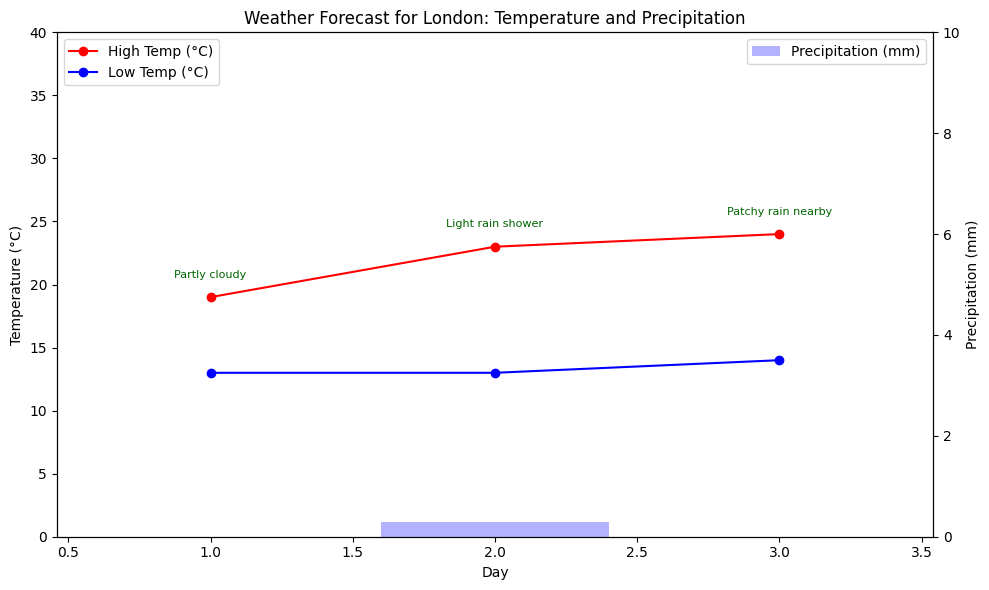


👕 CLOTHING ADVICE
Today in London: Partly cloudy skies with a high of 19°C and a low of 13°C, no precipitation expected.
Tomorrow: Watch out for Light rain showers, but the temperature will rise to 23°C (high) and still cool down to 13°C (low), with a slight amount of precipitation at 0.3mm.
Day after tomorrow: Be prepared for Patchy rain nearby. Despite this, it's expected to be warmer with high temperatures reaching up to 24°C and cooling down to 14°C during the night. No significant precipitation is forecasted (0.0mm).

Check another city? (y/yes to continue):
n
Goodbye! Have a nice day!


In [ ]:
# =====================================
# 2. Natural Language Processing
# =====================================
# Parse question
def parse_weather_question_ai(question):
    prompt = f"""
    Extract location, number of forecast days (1-5), and attribute (temperature, rain, outfit advice, general)
    from this question. Respond ONLY in JSON format like this:
    {{
      "location": "...",
      "forecast_days": ...,
      "attribute": "..."
    }}

    Question: "{question}"
    """

    response_text = get_ai_advice(prompt)
    try:
        parsed = json.loads(response_text)
        return parsed
    except json.JSONDecodeError:
        return {"location": None, "forecast_days": 1, "attribute": None}
    weather_data = get_weather_data(
      location=location,
      forecast_days=forecast_days,
      units='m'
    )


# Create prompt
def create_clothing_prompt_en(forecast):
    prompt = "Here is the weather forecast. Based on this information, please provide clothing advice in English.\n\n"
    for day in forecast:
        prompt += (f"Day {day['day']}: Weather: {day['condition']}, "
                   f"High: {day['high_temp']}°C, Low: {day['low_temp']}°C, "
                   f"Precipitation: {day['precipitation_mm']}mm\n")
    prompt += "\n👕 Clothing Advice:"
    return prompt


# Get AI advice
def get_ai_advice(prompt):
    try:
        response = requests.post(
            os.environ['HANDS_ON_AI_SERVER'] + "/v1/chat/completions",
            json={
                "model": os.environ['HANDS_ON_AI_MODEL'],
                "messages": [{"role": "user", "content": prompt}]
            },
            timeout=10
        )
        if response.status_code == 200:
            result = response.json()
            return result["choices"][0]["message"]["content"]
        else:
            return "Failed to get a response from the AI."
    except Exception as e:
        return f"Connection error to AI server: {e}"


# =====================================
# 3. Weather Data Functions
# =====================================
# Get weather data
def get_weather_data(location: str, forecast_days: int = 3, units='m') -> dict:
  try:
    if forecast_days < 1 or forecast_days > 5:
      return {"error": "forecast_days must be between 1 and 5"}

    response = fetch_my_weather.get_weather(
      location=location,
      units=units,
      view_options=str(forecast_days)
    )

    forecast = []
    raw_text = str(response)
    condition_pattern = r"weatherDesc=\[WeatherDesc\(value='([^']+)'\)\]"
    conditions = re.findall(condition_pattern, raw_text)

    max_temps = re.findall(r"maxtempC='(\d+)'", raw_text)
    min_temps = re.findall(r"mintempC='(\d+)'", raw_text)
    precips = re.findall(r"precipMM='([\d.]+)'", raw_text)

    for i in range(forecast_days):
      if i < len(max_temps) and i < len(min_temps) and i < len(precips):
        high = int(max_temps[i])
        low = int(min_temps[i])
        rain = float(precips[i])
        condition = conditions[i] if i < len(conditions) else "Unknown"

        forecast.append({
          "day": i + 1,
          "condition": condition,
          "high_temp": high,
          "low_temp": low,
          "precipitation_mm": float(rain)
        })

    return {
      "location": location,
      "forecast_days": len(forecast),
      "forecast": forecast
    }

  # Connection error
  except ConnectionError:
    print("Network error. Please check your connection and try again.")
    return None

  # Value error
  except ValueError as ve:
    print(f"Invalid input value: {ve}")
    return None

  # Unexpected error
  except Exception as e:
    print(f"An unexpected error occurred: {e}")
    return None

# Get day label
def get_day_label(day_number):
    if day_number == 1:
        return "Today"
    elif day_number == 2:
        return "Tomorrow"
    elif day_number == 3:
        return "Day after tomorrow"
    else:
        return f"Day {day_number}"


# =====================================
# 4. Visualisation Functions
# =====================================
# Show the weather forecast
def create_visualisation(forecast, location, output_type='display'):
  days = [entry['day'] for entry in forecast]
  high_temps = [entry['high_temp'] for entry in forecast]
  low_temps = [entry['low_temp'] for entry in forecast]
  precipitation = [entry['precipitation_mm'] for entry in forecast]

  fig, ax1 = plt.subplots(figsize=(10, 6))

  # Plot temperature lines on left y-axis
  ax1.plot(days, high_temps, color='red', marker='o', label='High Temp (°C)')
  ax1.plot(days, low_temps, color='blue', marker='o', label='Low Temp (°C)')
  ax1.set_xlabel('Day')
  ax1.set_ylabel('Temperature (°C)')
  ax1.legend(loc='upper left')
  ax1.set_ylim(0, 40)

  # Create second y-axis for precipitation bars
  ax2 = ax1.twinx()
  ax2.bar(days, precipitation, alpha=0.3, color='blue', label='Precipitation (mm)')
  ax2.set_ylabel('Precipitation (mm)')
  ax2.legend(loc='upper right')
  ax2.set_ylim(0, 10)

  for i, condition in enumerate([entry.get('condition', '') for entry in forecast]):
    ax1.annotate(
      condition,
      (days[i], high_temps[i] + 1),
      textcoords="offset points",
      xytext=(0, 5),
      ha='center',
      fontsize=8,
      color='darkgreen'
    )

  plt.title(f'Weather Forecast for {location}: Temperature and Precipitation')
  plt.tight_layout()
  safe_location = re.sub(r'\W+', '_', location)

  if output_type == 'figure':
    return fig
  elif output_type == 'save':
    plt.savefig(f"{forecast[0]['day']}_{safe_location}_forecast.png")
    print("Graph saved!")
    plt.close(fig)
  else:
    plt.show()
    plt.close(fig)

# Display weather forecast
def display_forecast(weather_data, days):
    print(f"Weather forecast for {weather_data.nearest_area[0].areaName[0].value}:\n")

    for day in weather_data.weather[:days]:
        date = day.date
        desc = day.hourly[4].weatherDesc[0].value.strip()
        max_temps = day.maxtempC
        min_temps = day.mintempC
        print(f"{date}: {desc}, Max: {max_temps}°C, Min: {min_temps}°C")


# =====================================
# 5. Main function
# =====================================
# Style
display(HTML('''
  <style>
  body {
    background-color: #f0f8ff !important;
  }
  </style>
  <div style="background-color: #f0f8ff; padding: 10px; border-radius: 10px;">
      <h2 style="color: #2e8b57;">🌤️ Weatherwise App</h2>
      <p style="font-size: 16px;">Get your outfit advice with style!</p>
  </div>
'''))

# Main
def main():
  print("Hi I'm Weatherwise App!")
  print("I can help you check the weather forecast.\n")

  while True:
    try:
      question = input("Ask me something about the weather:\n")
      parsed = parse_weather_question_ai(question)

      location = parsed.get("location") if parsed else None
      forecast_days = parsed.get("forecast_days", 1) if parsed else None

      while not location:
        location_input = input("Sorry, I didn't catch the location. Could you please tell me the city or place?\n").strip()
        parsed_location = parse_weather_question_ai(location_input)
        location = parsed_location.get("location") if parsed_location else None
        if not location:
          print("Still can't catch the location. Please try again.")

      while not forecast_days or not (1 <= forecast_days <= 3):
        days_input = input("How many days of forecast would you like? (1-3 days)\n").strip()
        try:
          parsed_days = parse_weather_question_ai(days_input)
          forecast_days_candidate = parsed_days.get("forecast_days") if parsed_days else None

          if forecast_days_candidate is None:
              forecast_days_candidate = int(days_input)

          if 1 <= forecast_days_candidate <= 3:
              forecast_days = forecast_days_candidate
          else:
              print("Please enter a number between 1 and 3.")
              forecast_days = None
        except ValueError:
          print("Please enter a valid number.")

      weather_data = get_weather_data(location=location, forecast_days=forecast_days)

      if not weather_data:
        print("Oops! No weather data returned.")
      elif "error" in weather_data:
        print(f"Oops! Something went wrong: {weather_data['error']}")
      elif not weather_data.get("forecast"):
        print("Oops! No forecast data received. Please try a different location or day range.")
      else:
        for day in weather_data["forecast"]:
          day_label = get_day_label(day['day'])
          print(f"- {day_label}: {day['condition']}, High: {day['high_temp']}°C, "
          f"Low: {day['low_temp']}°C, Precipitation: {day['precipitation_mm']} mm\n")

        create_visualisation(weather_data["forecast"], location)
        prompt_en = create_clothing_prompt_en(weather_data["forecast"])
        advice_en = get_ai_advice(prompt_en)
        print("\033[1m\n👕 CLOTHING ADVICE\033[0m")
        prompt = f"""
        Please answer the weather advice using 'Today', 'Tomorrow', and 'Day after tomorrow' instead of 'Day 1', 'Day 2', etc.
        Here is the weather data: {weather_data}
        """
        advice = get_ai_advice(prompt)
        print(advice)


      again = input("\nCheck another city? (y/yes to continue):\n").strip().lower()
      if again not in ['yes', 'y']:
        print("Goodbye! Have a nice day!")
        break

    except ConnectionError:
      print("It looks like there's a problem with your internet connection. Please check and try again.")
    except Exception as e:
      print(f"Oops! Something went wrong: {e}")
      print("Please try again or contact support if the issue persists.")


# =====================================
# 6. Main Script
# =====================================
if __name__ == '__main__':
    main()
